In [31]:
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import optax
from functools import partial
from typing import Callable
import time

from history import History

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from cmap import Colormap
cmap = Colormap('crameri:batlow').to_mpl()

In [32]:
from problems import Poisson3D
problem = Poisson3D()

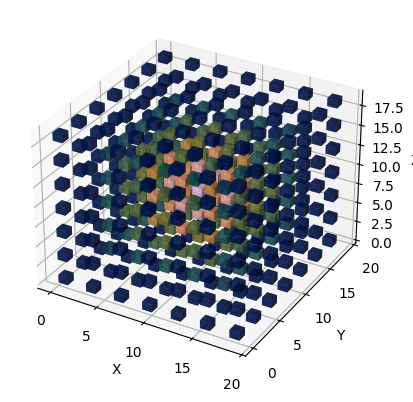

In [33]:
X, Y, Z, u_solution = problem.exact_solution(nx=7, ny=7, nz=7)

def explode(data):
    size = np.array(data.shape)*3
    data_e = np.zeros(size - 1, dtype=data.dtype)
    data_e[::3, ::3, ::3] = data
    return data_e

x_num = u_solution.shape[0]
y_num = u_solution.shape[1]
z_num = u_solution.shape[2]
filled = np.ones((x_num, y_num, z_num), dtype=bool)
filled_2 = explode(filled)
values_2 = explode(u_solution)
facecolors_2 = cmap(values_2)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.voxels(filled=filled_2, facecolors=facecolors_2, alpha=0.7)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [34]:
X, Y, Z, u_solution = problem.exact_solution(nx=32, ny=32, nz=32)

# Optimiser

In [35]:
class HistoryLM:
    """
    Levenberg-Marquardt optimiser.
    """

    def __init__(
        self,
        init_lambda=1e-3,
        decrease_factor: float = 5.0,
        increase_factor: float = 1.5,
        max_trials: int = 20,
        history_size: int = 10,
    ):
        self.init_lambda = init_lambda
        self.decrease_factor = decrease_factor
        self.increase_factor = increase_factor
        self.max_trials = max_trials
        self.history_size = history_size

    def init(self, params: eqx.Module):
        """Initialises the optimiser's state."""
        return {
            'lambda': jnp.asarray(self.init_lambda),
            'loss_history': jnp.full((self.history_size,), jnp.inf),
            'count': jnp.zeros((), dtype=jnp.int32),
        }

    def update(
        self,
        params: eqx.Module,
        state: optax.OptState,
        residual_fn: Callable[[eqx.Module], jax.Array]
    ):
        """Performs a single optimisation step."""
        
        current_lambda = state["lambda"]
        loss_history = state["loss_history"]
        params_flat, unflatten = jax.flatten_util.ravel_pytree(params)

        def flat_residual_fn(p_flat):
            return residual_fn(unflatten(p_flat))

        residuals = residual_fn(params)
        current_loss = jnp.mean(residuals**2)
        
        # --- Update history and get the 'high-water mark' reference loss ---
        new_loss_history = jnp.roll(loss_history, shift=-1).at[-1].set(current_loss)
        reference_loss = jnp.max(new_loss_history)

        J = jax.jacfwd(flat_residual_fn)(params_flat)
        U, S, Vt = jnp.linalg.svd(J, full_matrices=False)
        g = U.T @ residuals

        # --- JAX's while_loop to find an acceptable step ---
        # The loop state carries: (lambda_candidate, accepted, count, final_delta, final_loss)
        def evaluate_trial_step(loop_val):
            trial_lambda, _, trial_count, _, _ = loop_val
            
            # This is the standard LM update formula using SVD components
            delta = -Vt.T @ jnp.diag(S / (S**2 + trial_lambda)) @ g
            
            # Note: eqx.apply_updates is preferred over manual addition for safety
            trial_params_flat = params_flat + delta
            trial_residuals = flat_residual_fn(trial_params_flat)
            trial_loss = jnp.mean(trial_residuals**2)
            
            # THE ROBUST NON-MONOTONIC CHECK
            accepted = trial_loss < reference_loss
            
            # Update lambda for the *next* iteration based on outcome
            # Use a nested cond for the two-stage acceptance logic
            new_lambda = jax.lax.cond(
                accepted,
                lambda: trial_lambda,
                lambda: trial_lambda * self.increase_factor # Rejected
            )
            
            return new_lambda, accepted, trial_count + 1, delta, trial_loss

        def continue_search(loop_val):
            _, accepted, trial_count = loop_val[:3]
            return jnp.logical_and(jnp.logical_not(accepted), trial_count < self.max_trials)

        # Initial loop state
        init_loop_val = (current_lambda, False, 0, jnp.zeros_like(params_flat), jnp.inf)
        
        # Run the loop
        final_lambda, step_was_accepted, _, final_delta, final_loss = jax.lax.while_loop(
            continue_search, evaluate_trial_step, init_loop_val
        )
        
        updates = unflatten(final_delta)
        new_state = {
            'lambda': final_lambda * self.decrease_factor,
            'loss_history': new_loss_history,
            'count': state["count"] + 1
        }

        metrics = { 
            'loss': current_loss,
            'final_loss': final_loss,
            'step_accepted': step_was_accepted,
            'lambda': final_lambda,
            'reference_loss': reference_loss,
            'search_direction_norm': jnp.linalg.norm(final_delta),
        }

        return current_loss, updates, new_state, metrics


@partial(jax.jit, static_argnums=(3, 4))
def train_step(params, static_parts, opt_state, optimiser, problem, collocation_points):
    def residual_fn_for_optimizer(p):
        rebuilt_model = eqx.combine(p, static_parts)
        return problem.physics_residual(problem.residual_fn, rebuilt_model, collocation_points)

    loss, updates, new_opt_state, metrics = optimiser.update(params, opt_state, residual_fn_for_optimizer)
    new_params = eqx.apply_updates(params, updates)
    
    return new_params, new_opt_state, loss, metrics

In [ ]:
class HungryLM:
    """
    Levenberg-Marquardt optimiser.
    """

    def __init__(
        self,
        init_lambda=1e-3,
        decrease_factor: float = 0.75,
        increase_factor: float = 1.25,
        aggressive_factor: float = 0.75,
        max_trials: int = 20,
        steps_before_aggressive: int = 10,
        required_gain_before_aggressive: float = 0.9,
        #
        line_search_points: int = 11,
        line_search_min_factor: float = 0.5,
        line_search_max_factor: float = 1.5,
    ):
        self.init_lambda = init_lambda
        self.decrease_factor = decrease_factor
        self.increase_factor = increase_factor
        self.aggressive_factor = aggressive_factor
        self.max_trials = max_trials
        self.steps_before_aggressive = steps_before_aggressive
        self.required_gain_before_aggressive = required_gain_before_aggressive
        #
        self.line_search_points = line_search_points
        self.line_search_min_factor = line_search_min_factor
        self.line_search_max_factor = line_search_max_factor

    def init(self, params: eqx.Module):
        """Initializes the optimizer state with the initial damping factor."""
        return {
            'lambda': jnp.asarray(self.init_lambda),
            'loss_history': jnp.full((self.steps_before_aggressive,), jnp.inf),
        }

    def update(
        self,
        params: eqx.Module,
        state: optax.OptState,
        residual_fn: Callable[[eqx.Module], jax.Array]
    ):
        current_lambda = state['lambda']
        loss_history = state["loss_history"]
        params_flat, unflatten = jax.flatten_util.ravel_pytree(params)

        def flat_residual_fn(p_flat):
            return residual_fn(unflatten(p_flat))

        residuals = residual_fn(params)
        current_loss = jnp.mean(residuals**2)
        
        # --- Update history and get the 'high-water mark' reference loss ---
        new_loss_history = jnp.roll(loss_history, shift=-1).at[-1].set(current_loss)
        reference_loss = jnp.max(new_loss_history)

        J = jax.jacfwd(flat_residual_fn)(params_flat)
        U, S, Vt = jnp.linalg.svd(J, full_matrices=False)
        g = U.T @ residuals

        def _aggressive_step(c_lambda):
            """
            Branch 1: Not enough progress was made.
            """
            trial_lambda = c_lambda / self.decrease_factor * self.aggressive_factor
            delta = -Vt.T @ jnp.diag(S / (S**2 + trial_lambda)) @ g
            # We "accept" this forced step and report its lambda.
            return True, trial_lambda, delta, 1

        def _regular_lm_search(c_lambda):
            """
            Branch 2: Progress is good.
            """
            def evaluate_trial_step(loop_val):
                _, trial_lambda, _, trial_count = loop_val
                delta = -Vt.T @ jnp.diag(S / (S**2 + trial_lambda)) @ g
                
                trial_params = eqx.apply_updates(params, unflatten(delta))
                trial_residuals = residual_fn(trial_params)
                trial_loss = jnp.mean(trial_residuals**2)

                accepted = trial_loss < current_loss
                
                # If rejected, increase lambda for the next trial
                new_lambda = jax.lax.cond(
                    accepted,
                    lambda: trial_lambda,
                    lambda: trial_lambda * self.increase_factor
                )
                
                return accepted, new_lambda, delta, trial_count + 1

            def continue_search(loop_val):
                # Continue if step not accepted AND we haven't exceeded max trials
                accepted, _, _, trial_count = loop_val
                return jnp.logical_and(jnp.logical_not(accepted), trial_count < self.max_trials)
            
            # Run the search loop
            initial_loop_val = (False, c_lambda, jnp.zeros_like(params_flat), 0)
            accepted, final_lambda, final_delta, count = jax.lax.while_loop(
                continue_search, evaluate_trial_step, initial_loop_val
            )
            return accepted, final_lambda, final_delta, count


        not_enough_progress = current_loss > self.required_gain_before_aggressive * reference_loss

        step_was_accepted, final_lambda, lm_delta, trial_count = jax.lax.cond(
            not_enough_progress,
            _aggressive_step,
            _regular_lm_search,
            operand=current_lambda
        )

        updates = unflatten(lm_delta)
        
        new_state = {
            'lambda': final_lambda * self.decrease_factor,
            'loss_history': jax.lax.cond(
                not_enough_progress,
                lambda: jnp.full((self.steps_before_aggressive,), jnp.inf),
                lambda: new_loss_history
            )
        }
        
        metrics = { 
            'loss': current_loss,
            # 'line_search_best_loss': best_line_search_loss,
            'singular_values': S,
            'search_direction_norm': jnp.linalg.norm(lm_delta),
            'lambda': final_lambda,
            # 'best_alpha': best_alpha,
        }

        return current_loss, updates, new_state, metrics

In [102]:
key = jax.random.PRNGKey(42)

# --- Hyperparameters ---
n_collocation_points = 2**11
layer_sizes = [3, 16, 16, 16, 16, 16, 1]
# -----------------------

model_key, data_key = jax.random.split(key)
model = problem.FCN(model_key, layer_sizes)
params, static = eqx.partition(model, eqx.is_array)
history = History()
collocation_points = problem.get_collocation_points(n_collocation_points, seed=1)

optimiser = HungryLM(
    init_lambda=1e4,
    decrease_factor=0.9,
    increase_factor=1.01,
    aggressive_factor=0.8,
    steps_before_aggressive=20,
    max_trials=200,
    required_gain_before_aggressive=0.75,
)
opt_state = optimiser.init(params)

start_time = time.monotonic()

epoch = 0
for _ in range(500):
    epoch += 1
    
    params, opt_state, loss_val, metrics = train_step(
        params, static, opt_state, optimiser, problem, collocation_points
    )
    history.record(metrics)
    elapsed_seconds = time.monotonic() - start_time

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss_val.item():.3e}, Time elapsed: {elapsed_seconds:.2f} s")

model = eqx.combine(params, static)
print("Training complete.")

Epoch 5, Loss: 1.121e+02, Time elapsed: 7.89 s
Epoch 10, Loss: 9.518e+01, Time elapsed: 10.86 s
Epoch 15, Loss: 8.563e+01, Time elapsed: 13.66 s
Epoch 20, Loss: 6.000e+01, Time elapsed: 16.66 s
Epoch 25, Loss: 3.906e+01, Time elapsed: 19.38 s
Epoch 30, Loss: 1.665e+01, Time elapsed: 22.15 s
Epoch 35, Loss: 3.543e+00, Time elapsed: 24.71 s
Epoch 40, Loss: 1.448e+00, Time elapsed: 27.07 s
Epoch 45, Loss: 7.037e-01, Time elapsed: 29.52 s
Epoch 50, Loss: 5.396e-01, Time elapsed: 32.03 s
Epoch 55, Loss: 3.753e-01, Time elapsed: 34.63 s
Epoch 60, Loss: 3.111e-01, Time elapsed: 37.02 s
Epoch 65, Loss: 2.055e-01, Time elapsed: 39.58 s
Epoch 70, Loss: 1.980e-01, Time elapsed: 42.10 s
Epoch 75, Loss: 1.218e-01, Time elapsed: 44.75 s
Epoch 80, Loss: 7.544e-02, Time elapsed: 47.40 s
Epoch 85, Loss: 6.008e-02, Time elapsed: 49.87 s
Epoch 90, Loss: 5.333e-02, Time elapsed: 52.43 s
Epoch 95, Loss: 3.532e-02, Time elapsed: 54.97 s
Epoch 100, Loss: 1.600e-02, Time elapsed: 57.39 s
Epoch 105, Loss: 1.46

In [104]:
u_pred = model.predict(X, Y, Z)

error = jnp.abs(u_solution - u_pred)
rel_l2_error = jnp.linalg.norm(error) / jnp.linalg.norm(u_solution)

print(f"Relative L2 Error: {rel_l2_error:.3e}")

Relative L2 Error: 1.383e-04


In [81]:
error2 = error[::5, ::5, ::5]
print(error2.shape)

(7, 7, 7)


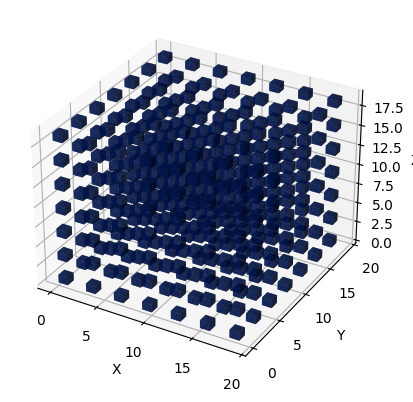

In [82]:
def explode(data):
    size = np.array(data.shape)*3
    data_e = np.zeros(size - 1, dtype=data.dtype)
    data_e[::3, ::3, ::3] = data
    return data_e

x_num = error2.shape[0]
y_num = error2.shape[1]
z_num = error2.shape[2]
filled = np.ones((x_num, y_num, z_num), dtype=bool)
filled_2 = explode(filled)
values_2 = explode(error2)
facecolors_2 = cmap(values_2)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.voxels(filled=filled_2, facecolors=facecolors_2, alpha=0.7)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

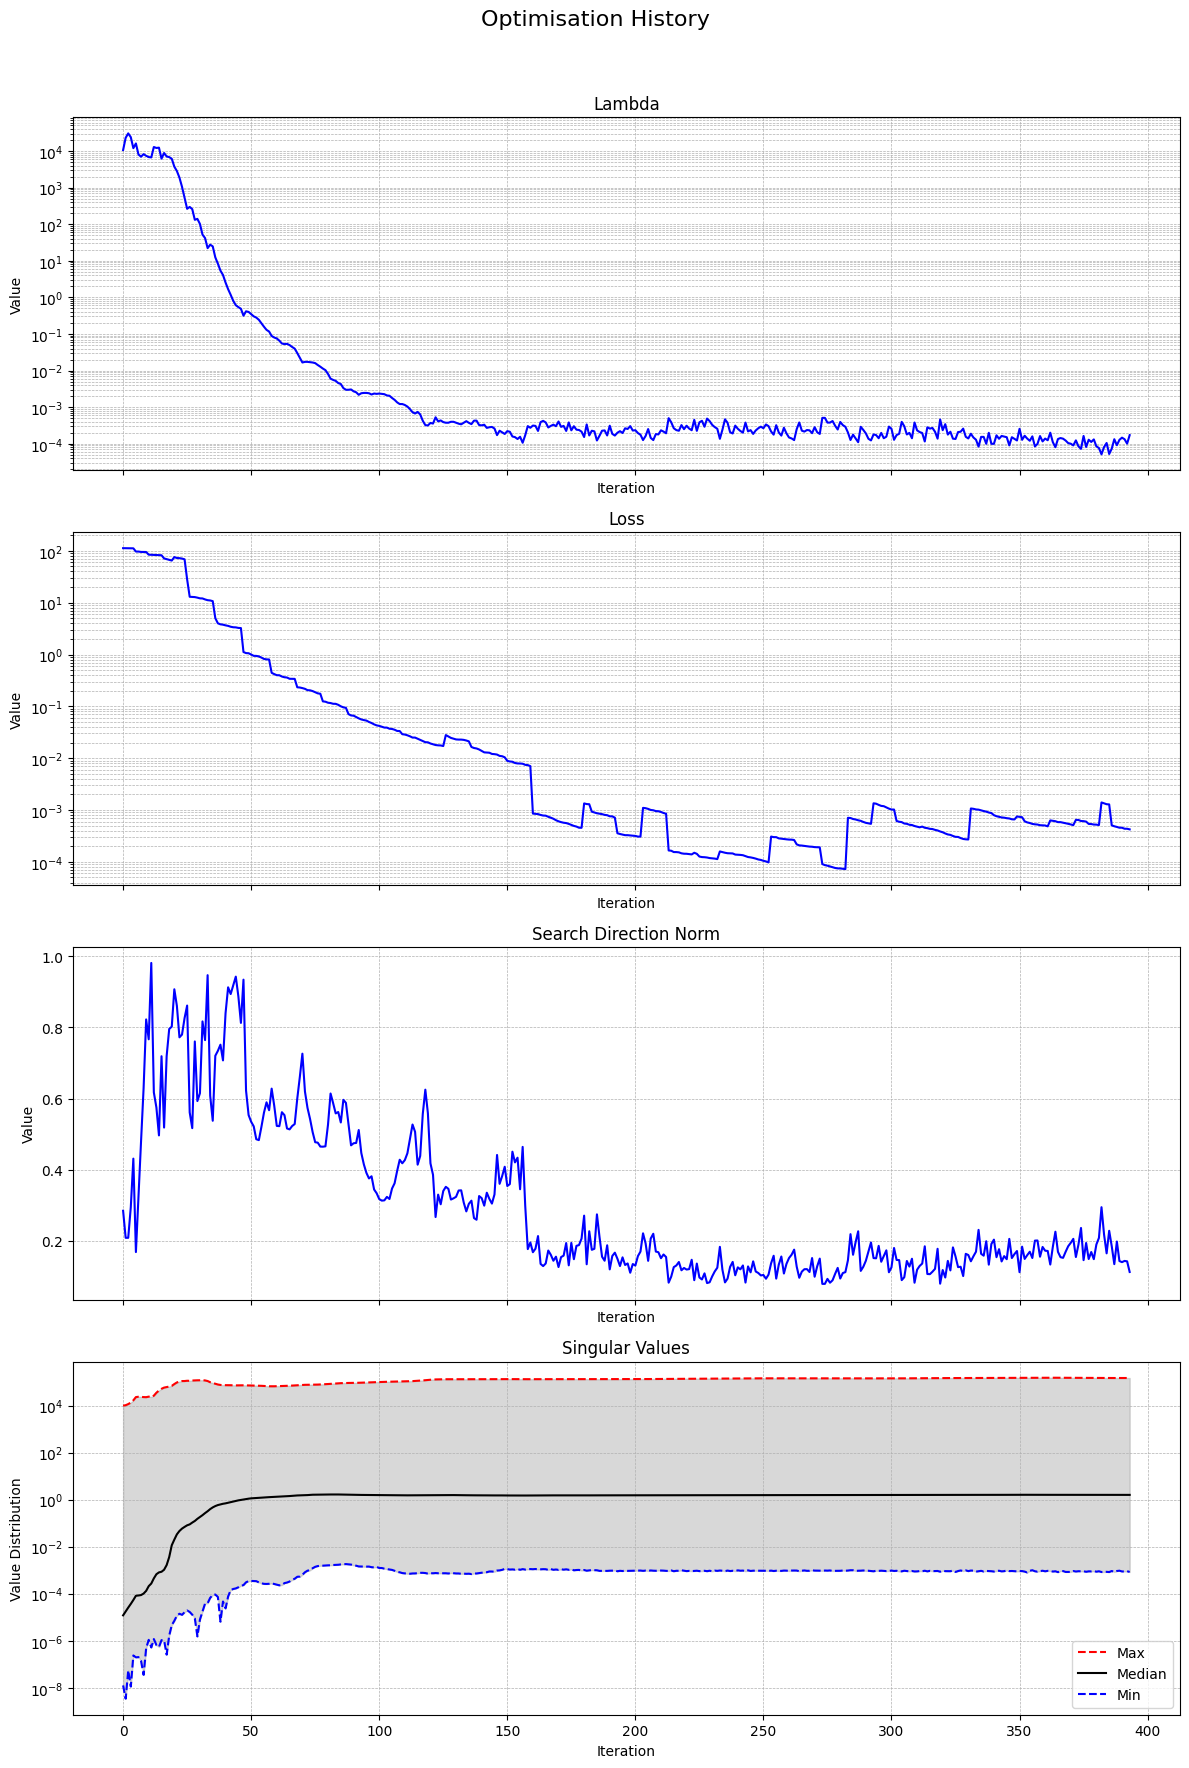

In [100]:
history.plot()